# Проект: Обучение с учителем: качество модели

**Название проекта**

Удержание активности постоянных клиентов интернет-магазина «В один клик» 

---

**Цель исследования**  

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

---
**Задачи исследования**

- Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
-  Собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

---
**Исходные данные**  

`market_file.csv`
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv`
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

`market_time.csv`
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

`money.csv`
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

## Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install shap -q


!pip install --upgrade numba -q
!pip install --upgrade scipy -q
!pip install --upgrade numpy -q
!pip install --upgrade seaborn -q
!pip install phik -q

In [2]:
#Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import phik

from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем метод оценки важности признаков в машинном обучении
from sklearn.inspection import permutation_importance

from phik.report import plot_correlation_matrix
from phik import report

In [3]:
#Загружаем данные о поведении покупателя на сайте
market_file = pd.read_csv('/datasets/market_file.csv')

#Загружаем данные о выручке
market_money = pd.read_csv('/datasets/market_money.csv')

#Загружаем данные о времени
market_time = pd.read_csv('/datasets/market_time.csv')

#Загружаем данные о среднемесячной прибыли покупателя за последние 3 месяца
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
# В целях оптимизации, напишем функцию для получения общей информации о датасете
def describe_df(df, name):
    print('размер датафрейма', name, ':', df.shape)
    print('_'*125)
    
    print('Первые 5 строк датафрейма', name)
    display(df.head())
    print('_'*125)
    
    print('Последнии 5 строк датафрейма', name)
    display(df.tail())
    print('_'*125)
    
    print('Информация о датафрейме', name)
    df.info()
    print('_'*125)
        
    print('Описание датафрейма', name)
    display(df.describe().T)
    print('_'*125)
    
    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())
    
    print('*'*125)

### market_file

In [5]:
#Вызовем функцию для датасета 'market_file'
describe_df(market_file, 'market_file')

размер датафрейма market_file : (1300, 13)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма market_file


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7
1299,216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12


_____________________________________________________________________________________________________________________________
Информация о датафрейме market_file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте market_file : 0
Количество пропусков в датафрейте market_file : 
 id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64
*****************************************************************************************************************************


In [6]:
#Приведем названия столбцов к типу стилю написания Snake case
#Приведем текст к нижнему регистру. Заменим пробелы на нижнее подчеркивание в названии столбцов
market_file.columns = market_file.columns.str.lower().str.replace(' ', '_')

In [7]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

**Вывод по общей информации в датафрейте market_file :**
* Явные дубликаты не обнаружены
* Типы столбцов указаны верно
* Пропущенных значений не выявленно
* Название столбцов приведены к единому стиля написания

### market_money

In [8]:
#Вызовем функцию для датасета 'market_money'
describe_df(market_money, 'market_money')

размер датафрейма market_money : (3900, 3)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма market_money


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма market_money


,id,Период,Выручка
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0
3899,216647,текущий_месяц,4448.3


_____________________________________________________________________________________________________________________________
Информация о датафрейме market_money
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма market_money


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте market_money : 0
Количество пропусков в датафрейте market_money : 
 id         0
Период     0
Выручка    0
dtype: int64
*****************************************************************************************************************************


In [9]:
#Приведем названия столбцов к типу стилю написания Snake case
#Приведем текст к нижнему регистру. Заменим пробелы на нижнее подчеркивание в названии столбцов
market_money.columns = market_money.columns.str.lower().str.replace(' ', '_')

In [10]:
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

**Вывод по общей информации в датафрейте market_money:**
* Явные дубликаты не обнаружены
* Типы столбцов указаны верно
* Пропущенных значений не выявленно
* Название столбцов приведены к единому стиля написания

### market_time

In [11]:
#Вызовем функцию для датасета 'market_time'
describe_df(market_time, 'market_time')

размер датафрейма market_time : (2600, 3)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма market_time


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма market_time


,id,Период,минут
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10
2599,216647,предыдцщий_месяц,15


_____________________________________________________________________________________________________________________________
Информация о датафрейме market_time
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма market_time


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте market_time : 0
Количество пропусков в датафрейте market_time : 
 id        0
Период    0
минут     0
dtype: int64
*****************************************************************************************************************************


In [12]:
#Приведем названия столбцов к типу стилю написания Snake case
#Приведем текст к нижнему регистру. Заменим пробелы на нижнее подчеркивание в названии столбцов
market_time.columns = market_time.columns.str.lower().str.replace(' ', '_')

In [13]:
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

**Вывод по общей информации в датафрейте market_time:**
* Явные дубликаты не обнаружены
* Типы столбцов указаны верно
* Пропущенных значений не выявленно
* Название столбцов приведены к единому стиля написания

### money

In [14]:
#Вызовем функцию для датасета 'money'
describe_df(money, 'money')

размер датафрейма money : (1300, 2)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма money


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма money


,id,Прибыль
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03
1299,216647,3.28


_____________________________________________________________________________________________________________________________
Информация о датафрейме money
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
_____________________________________________________________________________________________________________________________
Описание датафрейма money


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте money : 0
Количество пропусков в датафрейте money : 
 id         0
Прибыль    0
dtype: int64
*****************************************************************************************************************************


In [15]:
#Приведем названия столбцов к типу стилю написания Snake case
#Приведем текст к нижнему регистру. Заменим пробелы на нижнее подчеркивание в названии столбцов
money.columns = money.columns.str.lower().str.replace(' ', '_')

In [16]:
money.columns

Index(['id', 'прибыль'], dtype='object')

**Вывод по общей информации в датафрейте money:**
* Явные дубликаты не обнаружены
* Типы столбцов указаны верно
* Пропущенных значений не выявленно
* Название столбцов приведены к единому стиля написания

### Вывод по загрузке данных.

Данные соответствуют описанию, явных дубликатов нет, пропуски отсутствуют, типы столбцов указаны верно. Название столбцов приведены к единому стиля написания Snake case.

Проработка данных, а именно: выявление неявных дубликатов, аномальных значений и пр. будут произведены на следующих этапах обработки данных.


## Предобработка данных

*Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.*

In [17]:
# В целях оптимизации, напишем функцию для получения общей информации о столбце
def describe_column(df, column):
    print('Количество строк',  ':', df[column].shape[0])
    print('_'*125)
        
    print('Описание данных')
    display(df[column].describe().T)
    print('_'*125)
    
    print('Количество уникальных значений:', df[column].unique().shape[0])
    print('Количество пропусков в датафрейте', df[column].isna().sum())
    print('_'*125)
    
    if type(df[column].loc[1]) == str:
        print('Уникальные значения')
        print(df[column].value_counts())
    
    print('*'*125)

In [18]:
# Напишем функцию построения гистограммы и диграммы размаха для количественных данных
def hix_box_plot(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df[column].plot(ax=ax[0], kind='hist')
     
    sns.boxplot(df[column], ax=ax[1])
    
    ax[0].set_title('Гистограмма')
    ax[0].set_xlabel(column)
    
    ax[1].set_title('Диграмма размаха')
    ax[1].set_xlabel(column)

In [19]:
# Напишем функцию построения графика для категориальных данных

def bar_pie_plot(df, column):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    
    df.groupby(column)[column].count().plot(ax=ax[0], kind='bar')
    
    df.groupby(column)[column].count().plot(ax=ax[1], kind='pie', autopct='%1.0f%%')
    
        
    ax[0].set_title(f'Количественная диограмма')
    ax[1].set_title(f'Круговая диограмма')
    
    
    ax[0].tick_params(axis='x', labelrotation=0, labelsize = 15) 
    ax[1].set_ylabel('')

### market_file

#### id

In [20]:
market_file['id'].duplicated().sum()

0

**Вывод.** Все id уникальны.

#### Покупательская активность

In [21]:
#Выведем общую информацую
describe_column(market_file,'покупательская_активность')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count                1300
unique                  2
top       Прежний уровень
freq                  802
Name: покупательская_активность, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64
*****************************************************************************************************************************


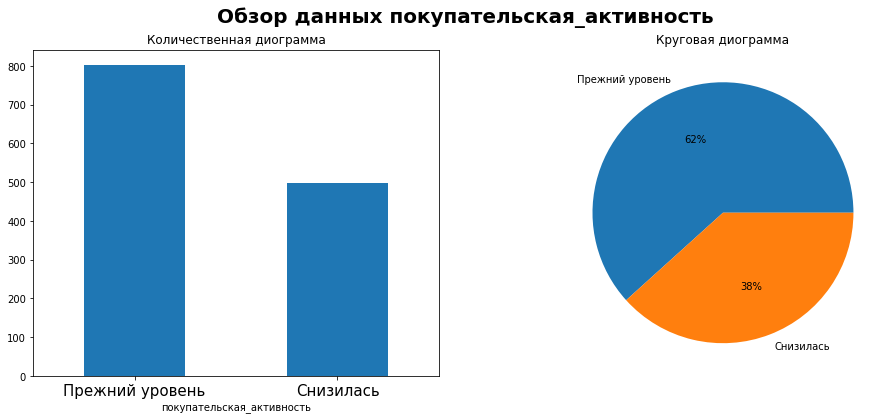

In [22]:
#Построим график
bar_pie_plot(market_file, 'покупательская_активность')

**Вывод** В столбце Покупательская активность. Представлены два значения «снизилась» или «прежний уровень». Соотношение данных 38% и 62% соответственно

#### Тип сервиса

In [23]:
#Выведем общую информацую
describe_column(market_file,'тип_сервиса')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count         1300
unique           3
top       стандарт
freq           914
Name: тип_сервиса, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64
*****************************************************************************************************************************


Видим, что в столбце всего 3 уникальных значения. Причем стандарт и стандартт - являются дубликатами.

In [24]:
#Заменим стандартт и стандарт
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')
market_file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

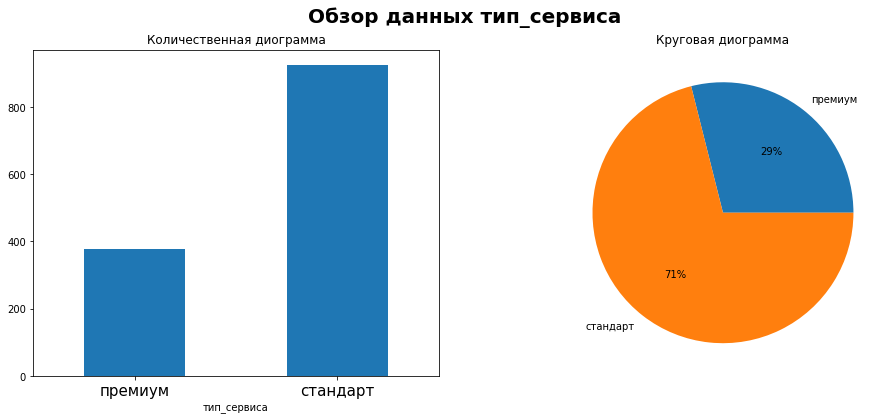

In [25]:
#Построим график
bar_pie_plot(market_file, 'тип_сервиса')

**Вывод** В столбце Тип сервиса, представлены два уровня сервиса «премиум» и «стандарт». 71 % пользователей пользуется сервисом «стандарт», 29% - «премиум».

#### Разрешить сообщать

In [26]:
#Выведем общую информацую
describe_column(market_file,'разрешить_сообщать')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count     1300
unique       2
top         да
freq       962
Name: разрешить_сообщать, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
да     962
нет    338
Name: разрешить_сообщать, dtype: int64
*****************************************************************************************************************************


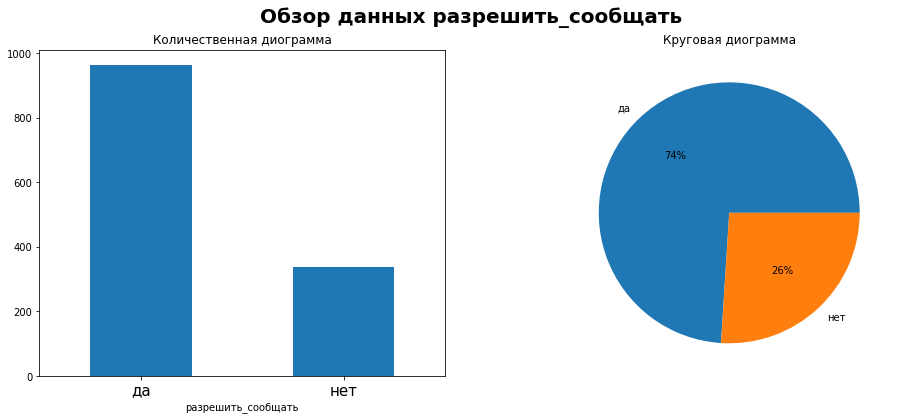

In [27]:
#Построим график
bar_pie_plot(market_file, 'разрешить_сообщать')

**Вывод.** Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Это бинарный признак. Согласие на него даёт покупатель. Из диаграммы видим, что 74% пользователей согласны получать дополнительные предложения о товаре, а 26% нет.

#### Маркет_актив _6 _мес

In [28]:
#Выведем общую информацую
describe_column(market_file,'маркет_актив_6_мес')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 41
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


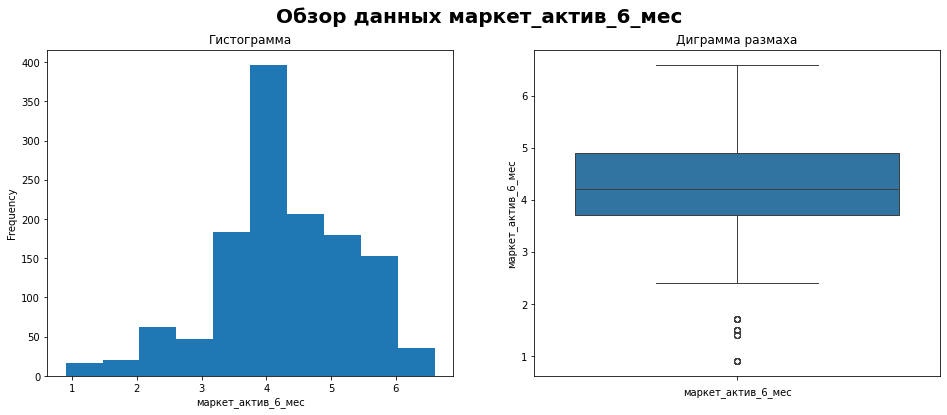

In [29]:
#Построим графики
hix_box_plot(market_file,'маркет_актив_6_мес')

In [30]:
#Процент выбросов
print('Количество выбросов, составляет:', market_file[market_file['маркет_актив_6_мес'] < 2.2].shape[0])
print('Доля выбросов, составляет:', market_file[market_file['маркет_актив_6_мес'] < 2].shape[0]/market_file.shape[0])

Количество выбросов, составляет: 36
Доля выбросов, составляет: 0.027692307692307693


**Вывод** В столбце Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. Есть выбросы. Процент выбросов небольшой всего 2,7%, но удалять их на данном шаге не будем, так как данные реалистичны по значениям. Возможно, это пользователи, которые не подошли ни под какую рассылку, либо отключили уведомления. 

#### Маркет_актив_тек_мес

In [31]:
#Выведем общую информацую
describe_column(market_file,'маркет_актив_тек_мес')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


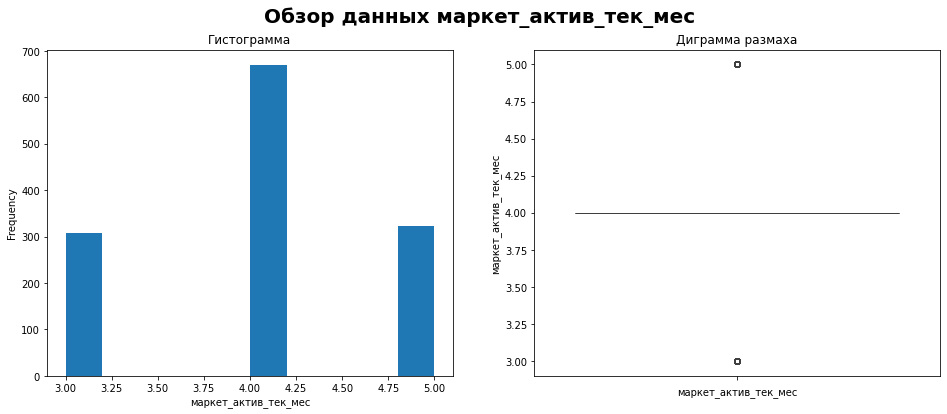

In [32]:
#Построим графики
hix_box_plot(market_file,'маркет_актив_тек_мес')

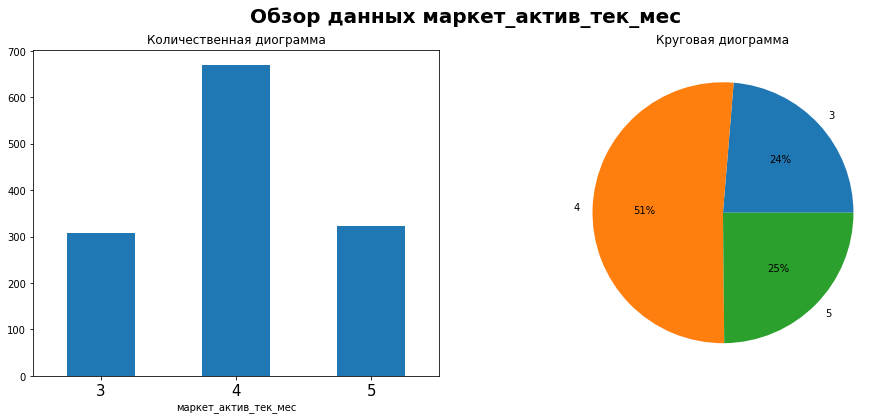

In [33]:
#Построим график
bar_pie_plot(market_file, 'маркет_актив_тек_мес')

**Вывод** В столбце Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце всего три уникальных значения. У 51% пользователей было 4 маркетинговых коммуникации в текущем месяце, у 24% и 25% пользователей было по 3 и 5 маркетинговых коммуникации в текущем месяце соответственно.

#### Длительность 

In [34]:
#Выведем общую информацую
describe_column(market_file,'длительность')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 658
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


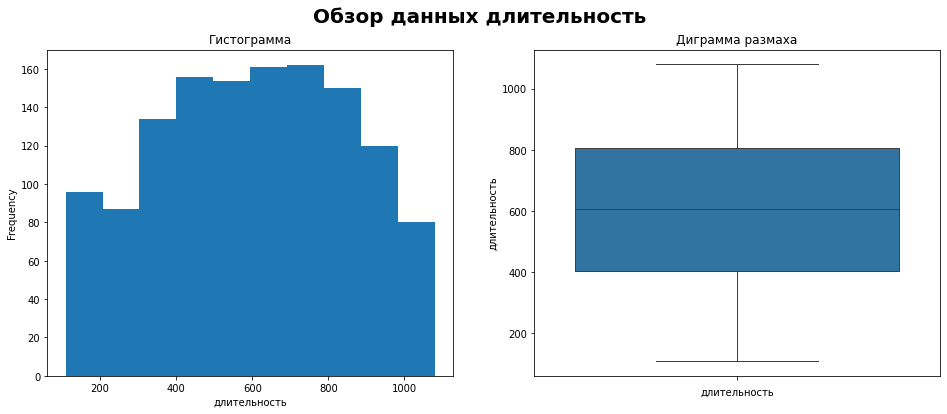

In [35]:
#Построим графики
hix_box_plot(market_file,'длительность')

**Вывод** В столбце Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте аномальных значений нет.

#### Акционные_покупки

In [36]:
#Выведем общую информацую
describe_column(market_file,'акционные_покупки')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 42
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


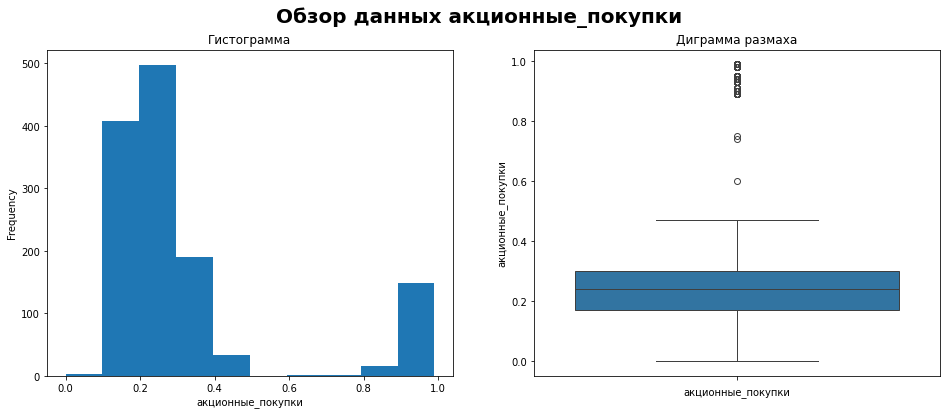

In [37]:
#Построим графики
hix_box_plot(market_file,'акционные_покупки')

In [38]:
#Процент выбросов
print('Доля выбросов, составляет:', market_file[market_file['акционные_покупки'] > 0.5].shape[0]/market_file.shape[0])

Доля выбросов, составляет: 0.12923076923076923


**Вывод** В столбце Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев есть выбросы. Процент выбросов составляет 13%, но удалять их на данном шаге не будем, так как данные реалистичны по значениям. Так как многие пользователи предпочитают покупать товары по акциям.

#### Популярная_категория

In [39]:
#Выведем общую информацую
describe_column(market_file,'популярная_категория')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count                 1300
unique                   6
top       Товары для детей
freq                   330
Name: популярная_категория, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 6
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64
*****************************************************************************************************************************


Text(0, 0.5, '')

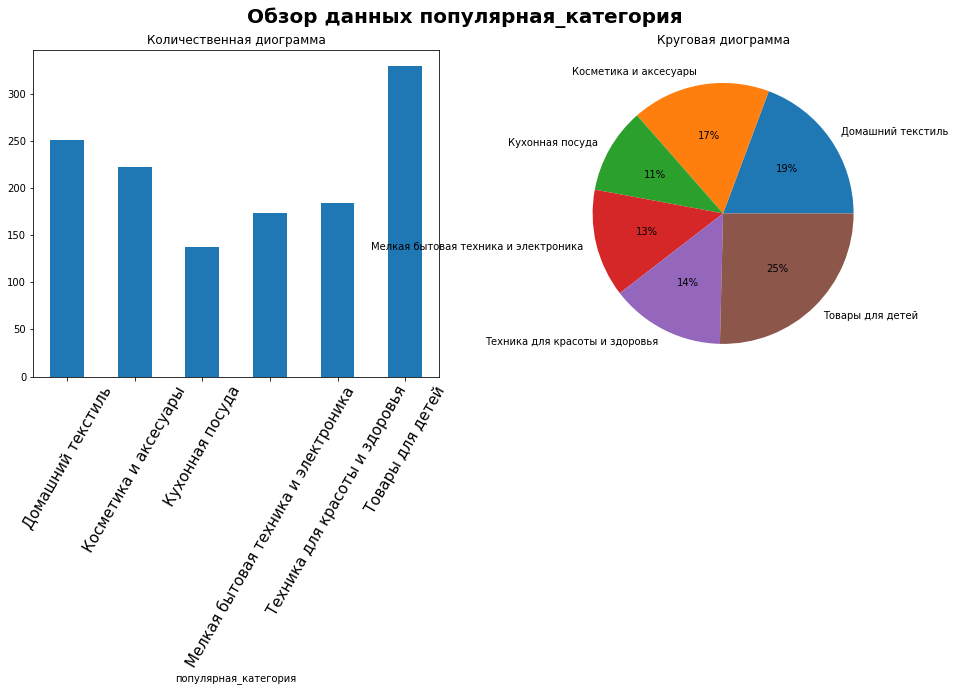

In [40]:
#Построим график
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle(f'Обзор данных популярная_категория', fontsize = 20, fontweight='bold')
    
market_file.groupby('популярная_категория')['популярная_категория'].count().plot(ax=ax[0], kind='bar')
    
market_file.groupby('популярная_категория')['популярная_категория'].count().plot(ax=ax[1], kind='pie', autopct='%1.0f%%')
    
        
ax[0].set_title(f'Количественная диограмма')
ax[1].set_title(f'Круговая диограмма')
    
    
ax[0].tick_params(axis='x', labelrotation=60, labelsize = 15) 

ax[1].set_ylabel('')

**Вывод.** В интернет-магазине «В один клик» часе всего заказывают товары для детей и домашний текстиль, реже всего посуду

#### Средний_просмотр_категорий_за_визит

In [41]:
#Выведем общую информацую
describe_column(market_file,'средний_просмотр_категорий_за_визит')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 6
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


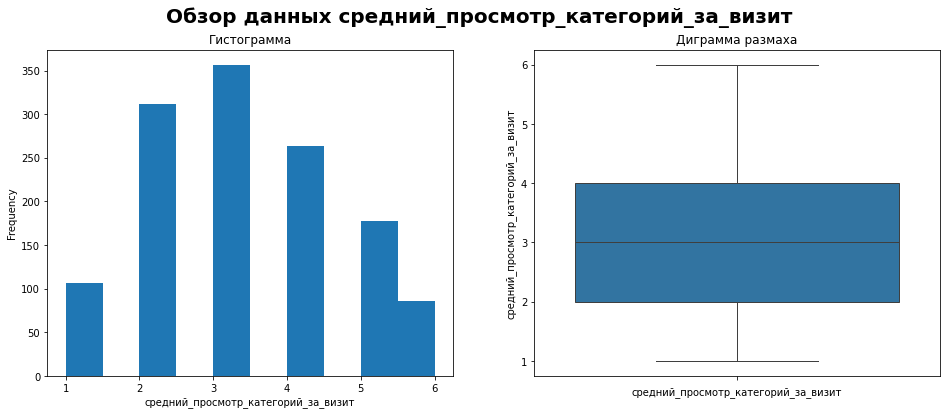

In [42]:
#Построим графики
hix_box_plot(market_file,'средний_просмотр_категорий_за_визит')

**Вывод** В среднем покупатель просматривает от 2 до 4 категории за визит в течение последнего месяца. 

#### Неоплаченные_продукты_штук_квартал

In [43]:
#Выведем общую информацую
describe_column(market_file,'неоплаченные_продукты_штук_квартал')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 11
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


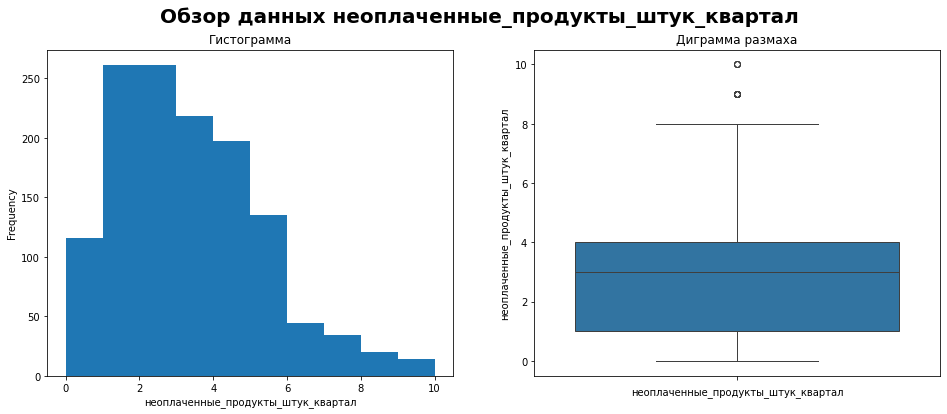

In [44]:
#Построим графики
hix_box_plot(market_file,'неоплаченные_продукты_штук_квартал')

In [45]:
#Процент выбросов
print('Доля выбросов, составляет:', market_file[market_file['неоплаченные_продукты_штук_квартал'] > 8].shape[0]/market_file.shape[0])

Доля выбросов, составляет: 0.010769230769230769


**Вывод** В столбце Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца есть выбросы. Процент выбросов составляет 1%, но удалять их на данном шаге не будем, так как данные реалистичны по значениям. 

#### Ошибка_сервиса

In [46]:
#Выведем общую информацую
describe_column(market_file,'ошибка_сервиса')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 10
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


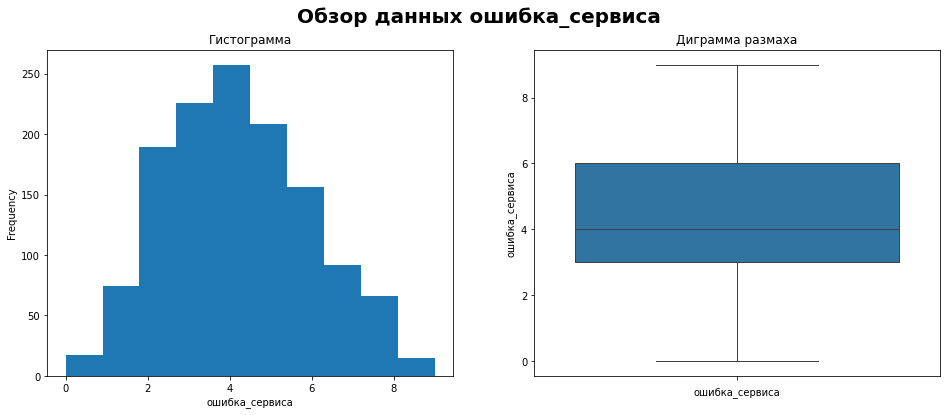

In [47]:
#Построим графики
hix_box_plot(market_file,'ошибка_сервиса')

**Вывод** Данные в столбце распределены нормально, выбросов нет. Среднее число сбоев, которые коснулись покупателя во время посещения сайта варьируется от 3 до 6.

#### Страниц_за_визит

In [48]:
#Выведем общую информацую
describe_column(market_file,'страниц_за_визит')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 20
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


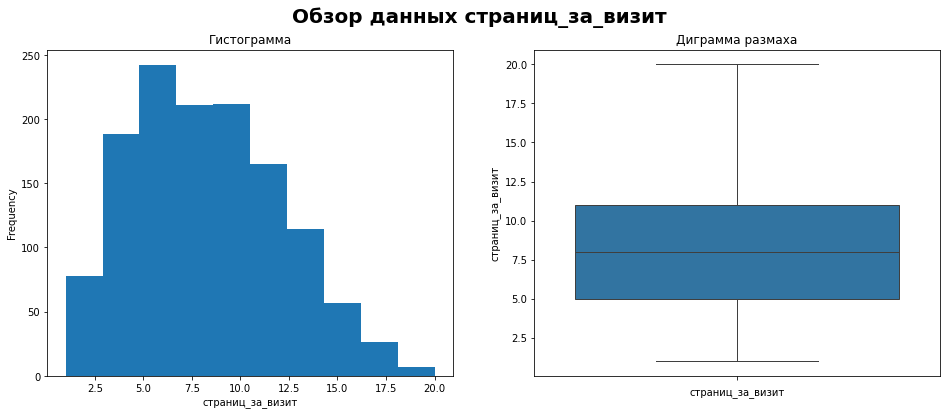

In [49]:
#Построим графики
hix_box_plot(market_file,'страниц_за_визит')

Вывод. Распределение данных напоминает распределение Пуассона. Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца варьируется от 5 до 11.

### market_money

#### Период

In [50]:
#Выведем общую информацую
describe_column(market_money,'период')

Количество строк : 3900
_____________________________________________________________________________________________________________________________
Описание данных


count              3900
unique                3
top       текущий_месяц
freq               1300
Name: период, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 3
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
текущий_месяц          1300
предыдущий_месяц       1300
препредыдущий_месяц    1300
Name: период, dtype: int64
*****************************************************************************************************************************


**Вывод** Видим, что в столбце всего 3 уникальных значения. На первый взгляд кажется, что значения предыдущий_месяц и препредыдущий_месяц - являются дубликатами, но это не так. Во первых во всех периодах 1300 значений, что соответствуют количуству пользователей в первом датафрейме, во-вторых в условии задачи сказано, что мы рассматриваем данные за 3 месяца. Значит значения соответствуют трем рассматриваемым месяцам

#### Выручка

In [51]:
#Выведем общую информацую
describe_column(market_money,'выручка')

Количество строк : 3900
_____________________________________________________________________________________________________________________________
Описание данных


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2776
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


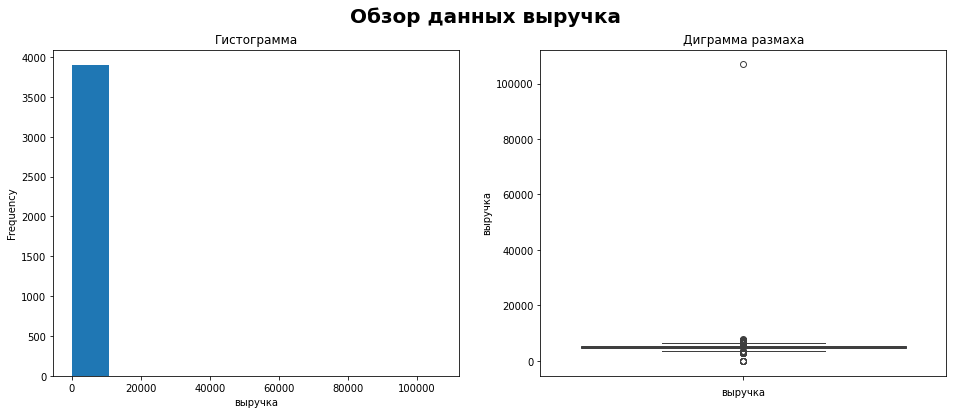

In [52]:
#Построим графики
hix_box_plot(market_money,'выручка')

In [53]:
#Посмотрим на количество выбросов
display(market_money[(market_money['выручка']>100000) | (market_money['выручка']<100)])

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0
98,215380,текущий_месяц,106862.2


**Вывод** В столбце Выручка есть аномальные значения, но удалять их на данном шаге не будем, так как данные реалистичны по значениям. Но примем эту информацию к сведению, возможна она понадобится при построении моделей, у далим уже после объединения таблиц. 

### market_time

#### Период

In [54]:
#Выведем общую информацую
describe_column(market_time,'период')

Количество строк : 2600
_____________________________________________________________________________________________________________________________
Описание данных


count              2600
unique                2
top       текущий_месяц
freq               1300
Name: период, dtype: object

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 2
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
Уникальные значения
текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64
*****************************************************************************************************************************


В столбце всего два уникальных значения, причем в слове предыдущий допущена опечатка, исправим ее

In [55]:
#Заменим стандартт и стандарт
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time['период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64

#### минут

In [56]:
#Выведем общую информацую
describe_column(market_time,'минут')

Количество строк : 2600
_____________________________________________________________________________________________________________________________
Описание данных


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 20
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


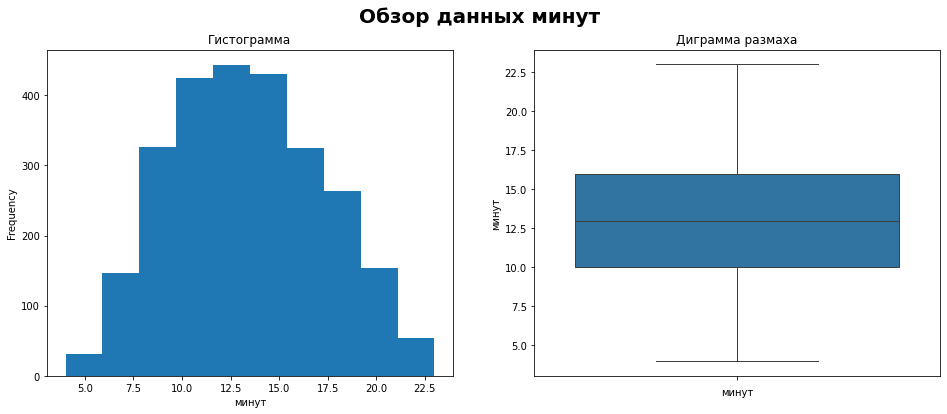

In [57]:
#Построим графики
hix_box_plot(market_time,'минут')

**Вывод.** Данные распределены нормально. Выбросов нет. Среднее значение времени, проведённого на сайте варьируется от 10 до 16 минут.

### money

#### Прибыль

In [58]:
#Выведем общую информацую
describe_column(money,'прибыль')

Количество строк : 1300
_____________________________________________________________________________________________________________________________
Описание данных


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

_____________________________________________________________________________________________________________________________
Количество уникальных значений: 400
Количество пропусков в датафрейте 0
_____________________________________________________________________________________________________________________________
*****************************************************************************************************************************


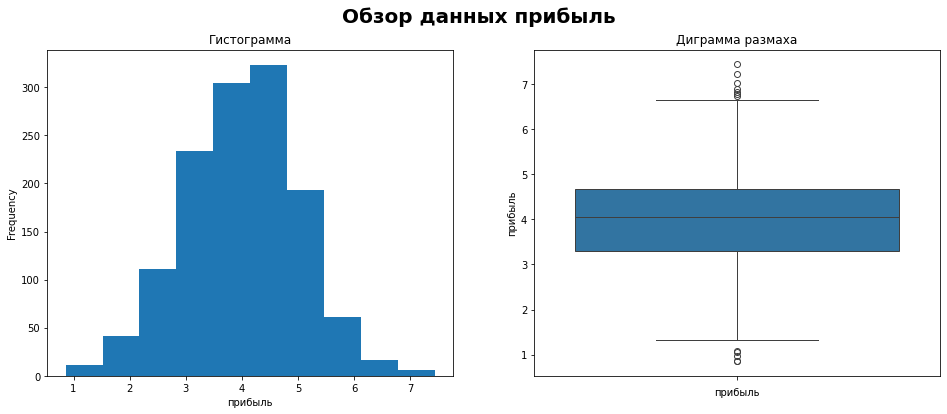

In [59]:
#Построим графики
hix_box_plot(money,'прибыль')

In [60]:
#Посмотрим на количество выбросов
display(money[(money['прибыль']>6.6) | (money['прибыль']<1.2)])

,id,прибыль
0,215348,0.98
52,215400,6.73
53,215401,7.43
182,215530,1.06
215,215563,6.88
637,215985,6.78
774,216122,0.86
817,216165,7.02
862,216210,6.65
920,216268,6.81


In [61]:
#Процент выбросов
print('Доля выбросов, составляет:', money[(money['прибыль']>6.6) | (money['прибыль']<1.2)].shape[0]/money.shape[0])

Доля выбросов, составляет: 0.01


**Вывод** В столбце прибыль есть аномальные значения, но удалять их на данном шаге не будем, так как данные реалистичны по значениям. Но примем эту информацию к сведению, возможна она понадобится при построении моделей, у далим уже после объединения таблиц.

In [62]:
#Убедимся, что после всех манипуляций с данными не появились дубликаты. 
print('Количество явных дубликатов в датафрейте market_file:',  market_file.duplicated().sum())
print('Количество явных дубликатов в датафрейте market_money:',  market_money.duplicated().sum())
print('Количество явных дубликатов в датафрейте market_time:',  market_time.duplicated().sum())
print('Количество явных дубликатов в датафрейте money:',  money.duplicated().sum())

Количество явных дубликатов в датафрейте market_file: 0
Количество явных дубликатов в датафрейте market_money: 0
Количество явных дубликатов в датафрейте market_time: 0
Количество явных дубликатов в датафрейте money: 0


### Вывод по предобработке данных

Данные в таблицах реалистичны и соответствуют описанию. 

На этапе предобработке данных проверили, что в данных:
- нет пропусков
- нет дубликатов
- типы столбцов указаны верно
- исправили опечатки

В данных встречаются выбросы, но они реалистичны по значениям. На текущем этапе обработки данных удалять их не будем, но данную информацию приняли ко вниманию.

Выбросы встретились в столбцах:
- 'маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал'  `market_file`
- 'выручка' датафрейма `market_money`
- 'прибыль' датафрейма `money`


## Исследовательский анализ данных

*Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.*

Исследовательский анализ данных был проведен на шаге с предобработкой данных. Так как выбросы реалистичны по значениям на данном этапе удалять не будем. 

---

Чтобы отобрать клиентов с покупательской активностью не менее трёх месяцев, можно просто взять пользователей из таблицы money. Так как данная таблица содержит данные о среднемесячной прибыли покупателя за последние 3 месяца. 

In [63]:
money[money['прибыль'] == 0].shape[0]

0

Так как пользователей с нулевой выручкой в таблице нет, значит все пользователи совершали покупки в течение последних 3 месяцев. 

## Объединение таблиц

*4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся.* 

*4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.*

Так как столбец период есть в двух разных датафреймах, пержде чем объединять данны переменуем их.

In [64]:
market_file = market_file.set_index('id') 
market_money = market_money.set_index('id') 
market_time = market_time.set_index('id') 

In [65]:
pivot_table= market_money.pivot_table(index=['id'], columns = 'период',values = 'выручка').reset_index()
pivot_table= pivot_table.set_index('id') 
pivot_table.columns

Index(['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'], dtype='object', name='период')

In [66]:
market_full = market_file.join(pivot_table)
market_full.rename(columns = {'предыдущий_месяц':'предыдущий_месяц_выручка', 
                    'препредыдущий_месяц':'препредыдущий_месяц_выручка',
                    'текущий_месяц':'текущий_месяц_выручка'}, inplace = True )
market_full.head(1)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка
id,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,0.0,0.0,3293.1


In [67]:
pivot_table= market_time.pivot_table(index=['id'], columns = 'период',values = 'минут').reset_index()
pivot_table= pivot_table.set_index('id') 
pivot_table.columns

Index(['предыдущий_месяц', 'текущий_месяц'], dtype='object', name='период')

In [68]:
market_full = market_full.join(pivot_table)
market_full.rename(columns = {'предыдущий_месяц':'предыдущий_месяц_время', 
                    'текущий_месяц':'текущий_месяц_время'}, inplace = True )
market_full.head(1)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14


In [69]:
#Вызовем функцию для датасета 'market_file'
describe_df(market_full, 'market_full')

размер датафрейма market_full : (1300, 17)
_____________________________________________________________________________________________________________________________
Первые 5 строк датафрейма market_full


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


_____________________________________________________________________________________________________________________________
Последнии 5 строк датафрейма market_full


,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7
216647,Прежний уровень,премиум,да,4.0,5,906,0.94,Техника для красоты и здоровья,4,5,3,12,4720.0,5183.0,4448.3,15,10


_____________________________________________________________________________________________________________________________
Информация о датафрейме market_full
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1300 non-null   object 
 1   тип_сервиса                          1300 non-null   object 
 2   разрешить_сообщать                   1300 non-null   object 
 3   маркет_актив_6_мес                   1300 non-null   float64
 4   маркет_актив_тек_мес                 1300 non-null   int64  
 5   длительность                         1300 non-null   int64  
 6   акционные_покупки                    1300 non-null   float64
 7   популярная_категория                 1300 non-null   object 
 8   средний_просмотр_категорий_за_визит  1300 non-null   int64 

,count,mean,std,min,25%,50%,75%,max
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.900,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.000,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.000,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.300,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.000,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.000,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.000,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.000,20.00
предыдущий_месяц_выручка,1300.0,4936.920385,739.597997,0.0,4496.75,5005.00,5405.625,6869.50
препредыдущий_месяц_выручка,1300.0,4825.206923,405.979663,0.0,4583.00,4809.00,5053.500,5663.00


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте market_full : 11
Количество пропусков в датафрейте market_full : 
 покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц_выручка               0
препредыдущий_месяц_выручка            0
текущий_месяц_выручка                  0
предыдущий_месяц_время                 0
текущий_месяц_время                    0
dtype: int64
********************************************************

Объединения данных прошло успешно. Пропусков, дубликатов в данных нет. Типы столбцов указаны верно 

In [70]:
# удалим клиентов которые не совершали покупок, хотя бы в одном из трех месяцев, 
#а так же клиента с анамально большой выручкой в текущем месяце
market_full = market_full[(market_full['предыдущий_месяц_выручка']>0) & 
                          (market_full['препредыдущий_месяц_выручка']>0) &
                          (market_full['текущий_месяц_выручка']>0) &
                          (market_full['текущий_месяц_выручка']<100000)]


market_full.head(1)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10


## Корреляционный анализ

*Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.*

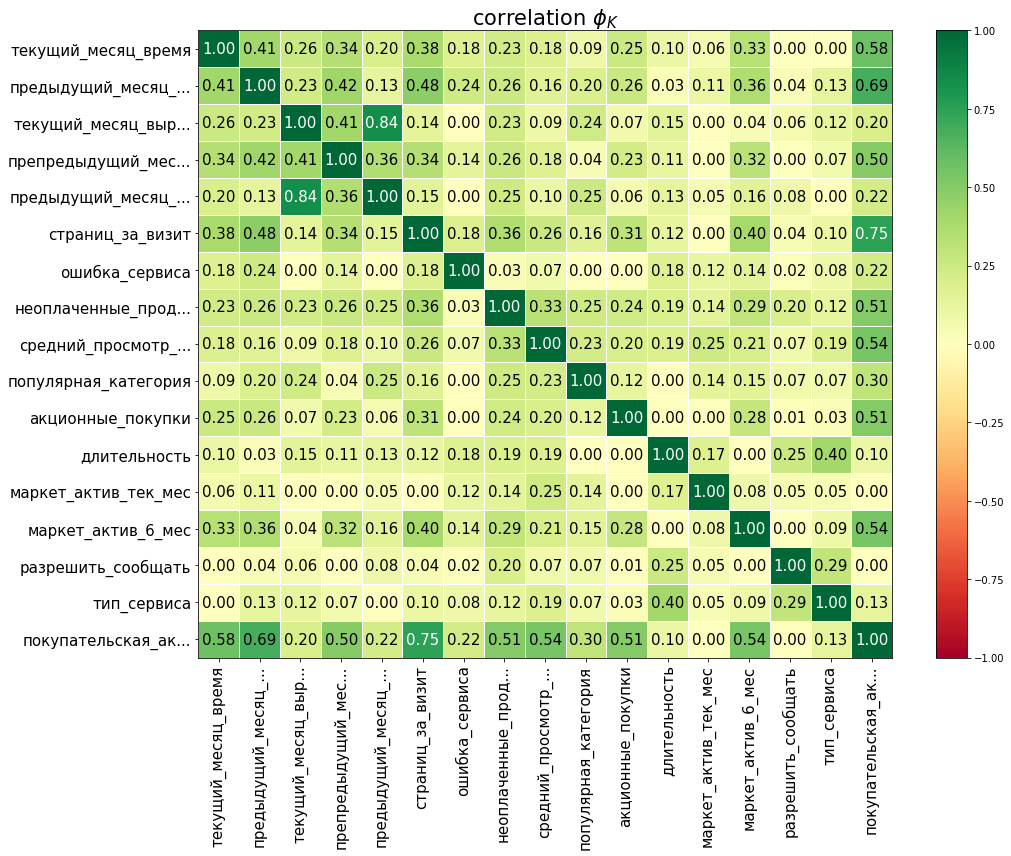

In [73]:
# Мамрица корреляции с указанием численных солбцов

# список интервальных признаков
interval_cols = market_full.select_dtypes(include='number').columns.tolist()

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = market_full.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Вывод**

Из матрицы видем, что признаки препредыдущий_месяц_выручка/предыдущий_месяц_выручка/текущий_месяц_выручка коррелируют между собой.

Данную связь легко объяснить, интернет-магазин «В один клик» продаёт разные товары. Если человек привык покупать определенный набор продуктов, моющих средств и других товаров необходимых в ежедневном использовании, то большая доля вероятности, что он купит эти же товары и в следующем месяце. Как правило одни и те же типы товаров мы покупаем в одних и тех же магазинах (так как в качестве товара ты уже уверен и времени на поиск товара занимает меньше). Отсюда и выручка от одних и тех же клиентов остается стабильной. Но избавляться хоть от одного из них считаю некорректно, если удалим хоть один из них, то уже не сможем правильно предсказывать активность пользователей.

Связь между покупательской активностью и другими признаками, тоже объяснима:
- покупательская активность/выручка. Чем больше выручка, тем выше покупательская активность
- покупательская активность/страниц_за_визит. Чем больше товаров просмотрел пользователь, тем выше покупательская активность
- покупательская активность/время на сайте. Чем больше времени пользователь проводит на сайте, тем выше покупательская активность

##  Использование пайплайнов

*Примените все изученные модели. Для этого используйте пайплайны.*

*6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.*

*Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.*

*6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.*

*6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:*
- *использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;*

- *использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.*

### Использование пайплайнов 

In [75]:
#создание констант RANDOM_STATE и TEST_SIZE
RANDOM_STATE = 42
TEST_SIZE = 0.25

#разобьем данные 
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

X_train.shape, X_test.shape

((972, 16), (324, 16))

In [76]:
# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность','акционные_покупки',
              'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
              'страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка','текущий_месяц_выручка',
               'предыдущий_месяц_время','текущий_месяц_время']


In [77]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )


In [78]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


In [79]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


In [80]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [81]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели CVС()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__kernel': ['linear', 'rbf']
    }
    
       
]

In [82]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

**Выбор подходящей метрики**

Для решения данной задачи будем использовать метрику *ROC AUC*. 

Преимущества данной метрики в том, что ее можно использовать, когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Также в контексте обнаружения выбросов ROC AUC предпочтительнее других метрик, особенно когда классы несбалансированы, объектов с одним значением целевого признака больше, чем с другими. ROC AUC устраняет проблему несбалансированных данных, предоставляя более надежную оценку производительности модели. 


In [83]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                        

### Вывод 

Лучшая модель: SVC(probability=True, random_state=42)

Метрика лучшей модели на тренировочной выборке: 0.90

Метрика ROC-AUC на тестовой выборке: 0.92

##  Анализ важности признаков

*7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP.* 

*7.2 Сделайте выводы о значимости признаков:*
- *какие признаки мало значимы для модели;*
- *какие признаки сильнее всего влияют на целевой признак;*
- *как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.*

In [88]:
# Зададим лучшую модель из результатов RandomizedSearchCV
best_model = SVC(probability=True, random_state=42)

In [89]:
# Предобработка данных через пайплайн 
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Получаем имена признаков после кодирования
ohe_columns_preprocessed = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_columns_preprocessed = ord_columns
num_columns_preprocessed = num_columns

# Объединяем все имена признаков в один список
all_columns_preprocessed = np.concatenate([ohe_columns_preprocessed, ord_columns_preprocessed, num_columns_preprocessed])

# Создаем DataFrame с соответствующими именами колонок
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_columns_preprocessed)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_columns_preprocessed)

# Обучаем модель
best_model.fit(X_train_preprocessed_df, y_train)

SVC(probability=True, random_state=42)

In [90]:
# Оценка важности переменных методом Permutation Feature Importance
perm_importance = permutation_importance(best_model, X_test_preprocessed_df, y_test, random_state=42,
                                        n_repeats=10,scoring='roc_auc')
perm_importance_df = pd.DataFrame({'Feature': all_columns_preprocessed, 'Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
perm_importance_df

,Feature,Importance
14,страниц_за_визит,0.014760
11,средний_просмотр_категорий_за_визит,0.012765
10,акционные_покупки,0.011524
18,предыдущий_месяц_время,0.009704
19,текущий_месяц_время,0.007358
4,популярная_категория_Техника для красоты и здо...,0.006464
5,популярная_категория_Товары для детей,0.003834
16,препредыдущий_месяц_выручка,0.003790
1,популярная_категория_Косметика и аксесуары,0.003782
7,маркет_актив_6_мес,0.003592


<Axes: ylabel='Feature'>

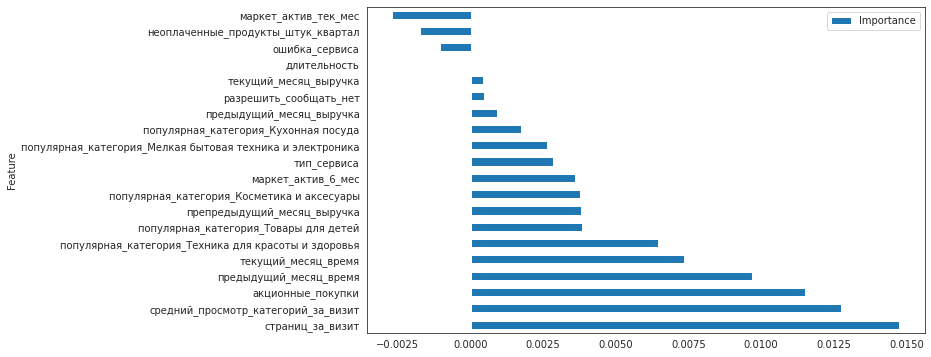

In [91]:
# представим результат графически
sns.set_style('white')
perm_importance_df.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

<div class="alert alert-info">
**Комментарий студента** Данный код выполняется 7,5 минут. Надо подождать)
</div>

  0%|          | 0/10 [00:00<?, ?it/s]

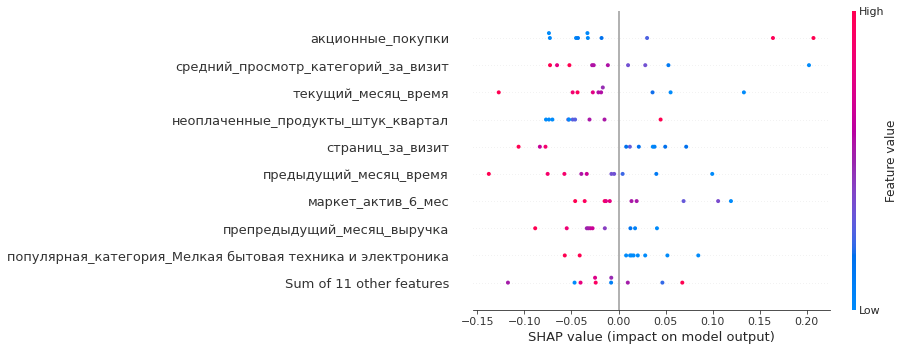

In [92]:
#Инициализируем объект KernelExplainer из библиотеки SHAP
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_df[:10])

#вычислим значения SHAP для подмножества тестового набора данных
shap_values = explainer(X_test_preprocessed_df[:10])[:,:,1]

shap.plots.beeswarm(shap_values)

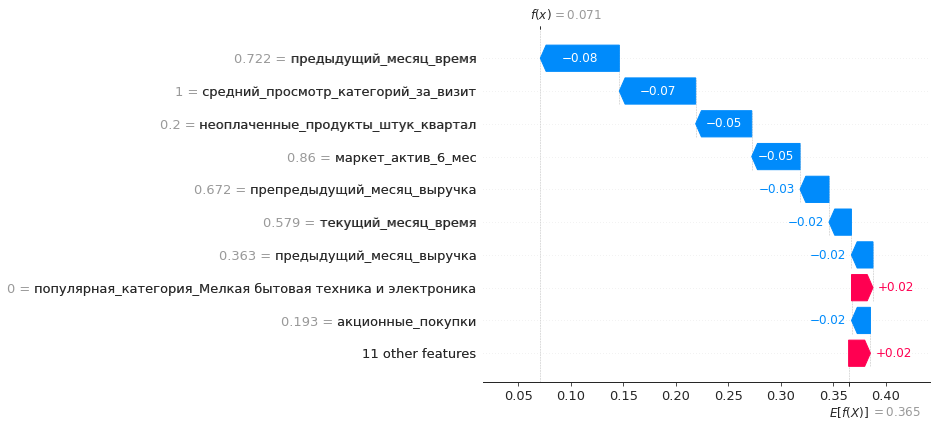

In [93]:
shap.plots.waterfall(shap_values[5]) 

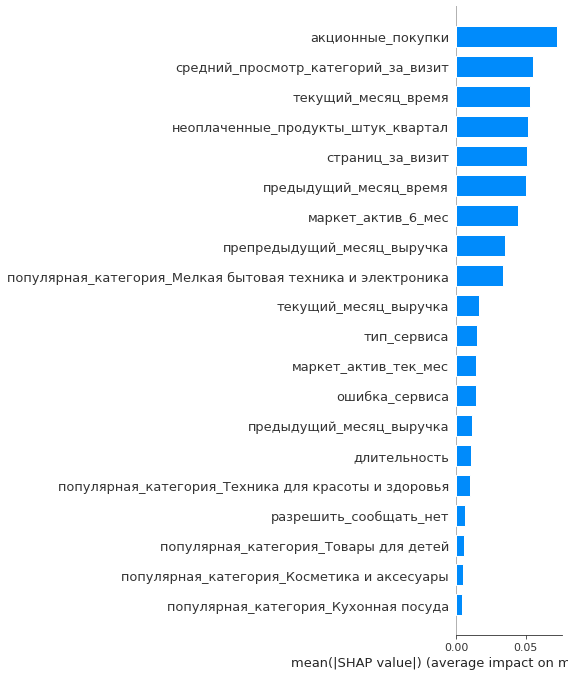

In [94]:
shap.summary_plot(shap_values, X_train_preprocessed_df, plot_type='bar')

**Вывод** 

Наиболее важными признаками модели являются:
- страниц_за_визит важность	0.014760
- средний_просмотр_категорий_за_визит важность 0.012765

ошибка_сервиса (-0.001035), неоплаченные_продукты_штук_квартал (-0.001747), маркет_актив_тек_мес (-0.002702) имеют отрицательную важность, что означает, что они не вносят положительный вклад в модель.

---

Зная, какие признаки сильнее всего влияют на целевой признак, можно сконцентрироваться на сборе и анализе данных, связанных с этими признаками. Это может помочь в оптимизации модели и принятии более обоснованных бизнес-решений.

В нашем случае, чтобы удержать активность постоянных клиентов интернет-магазина «В один клик», можно предложить показывать в рекомендации товары, аналогичные тем, которые он смотрел в эту сессию, или даже в прошлом месяце, чтобы увеличить среднее количество страниц, которые просмотрел покупатель за один визит.

## Сегментация покупателей

*8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.*

*8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:*
- *Проведите графическое и аналитическое исследование группы покупателей.*
- *Сделайте предложения по работе с сегментом для увеличения покупательской активности.*

*8.3 Сделайте выводы о сегментах:*
- *какой сегмент вы взяли для дополнительного исследования,*
- *какие предложения вы сделали и почему.*

Сегментацию данных буду проводить на изначальном датафрейме, в котором уже есть целевой признак для сегментации 'Покупательская активность'.

В задании предлагается использовать результаты моделирования для сегментации покупателей, для этого нужно:
- определить порог классификации
- получить предсказания на изначальных данных
- применить значение порога к предсказаниям
- на основании этого прогноза делать сегментацию покупателей

В данном случае, считаю что делать прогноз на данных участвующих в обучении не корректно. Поэтому для сегментации пользователей буду брать готовый признак 'Покупательская активность'.

In [95]:
#Добавим данные о прибыли к изначальному датафрейму
money = money.set_index('id') 
market_full = market_full.join(money)
market_full.head(1)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,прибыль
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16


### Сегментация на изначально заданном признаке

In [96]:
#Определим количественные признаки
quantitative_variables = market_full.select_dtypes(include='number').columns.tolist()
quantitative_variables

['маркет_актив_6_мес',
 'маркет_актив_тек_мес',
 'длительность',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'ошибка_сервиса',
 'страниц_за_визит',
 'предыдущий_месяц_выручка',
 'препредыдущий_месяц_выручка',
 'текущий_месяц_выручка',
 'предыдущий_месяц_время',
 'текущий_месяц_время',
 'прибыль']

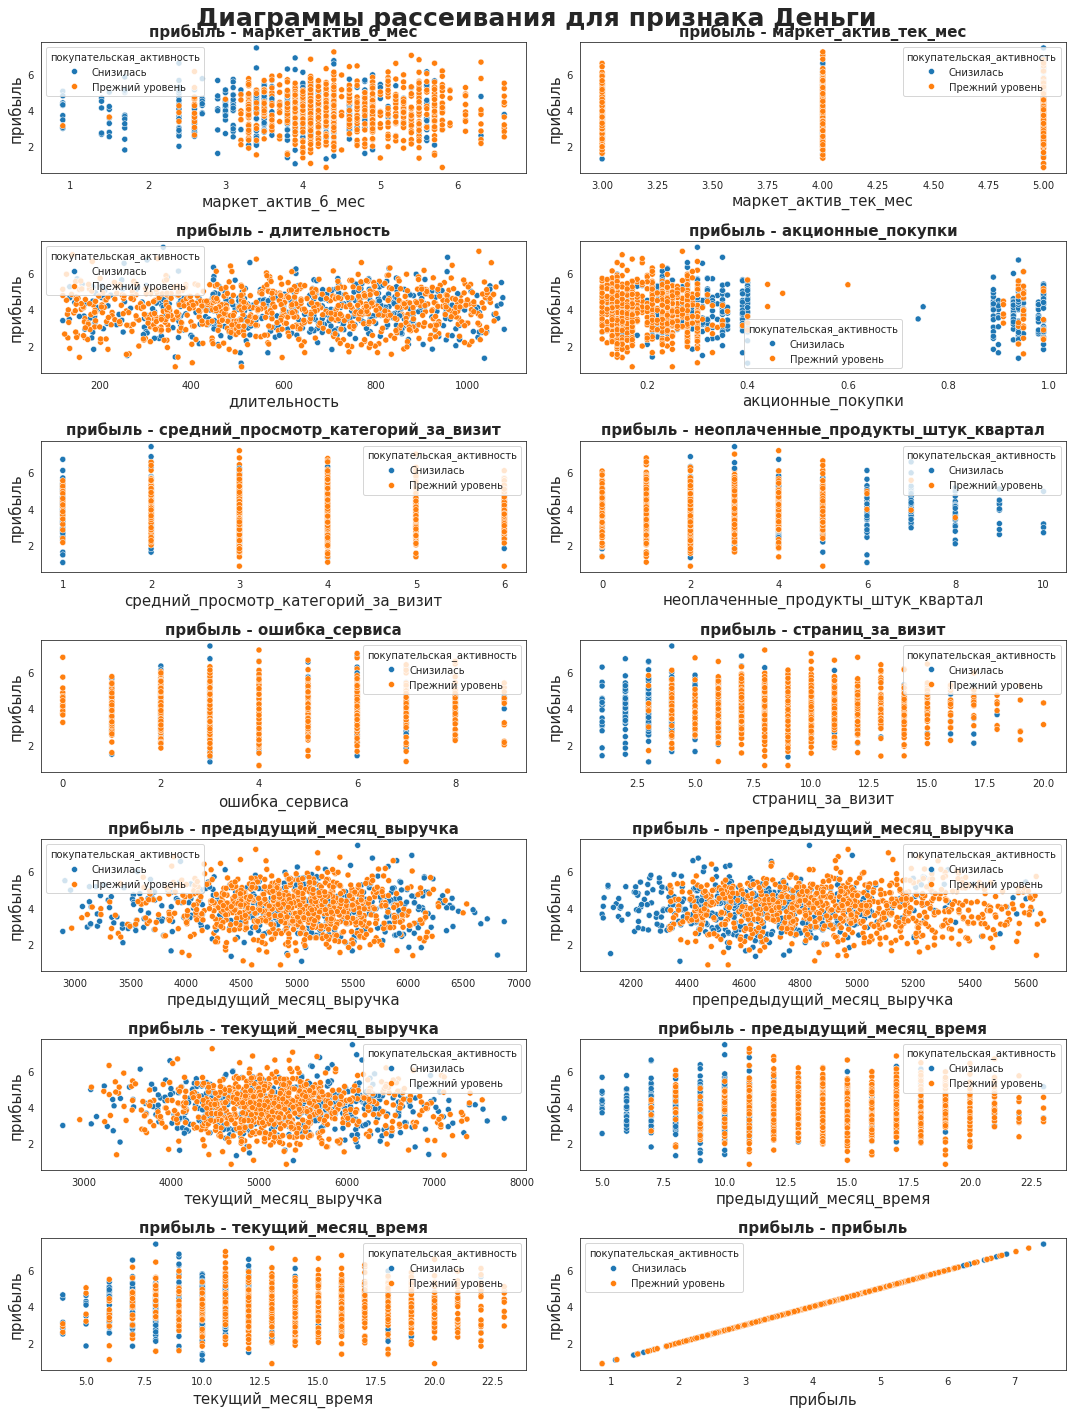

In [97]:
# Построим диагрраммы рассеивания для количественных переменных по признаку покупательская_активность
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,20))
fig.suptitle(f'Диаграммы рассеивания для признака Деньги', fontsize = 25, fontweight='bold')
temp = 1
for i in quantitative_variables:
    plt.subplot(7, 2, temp)
    sns.scatterplot(data=market_full, x=i, y='прибыль', hue='покупательская_активность')
    temp += 1
    plt.title(f'прибыль - {i}', fontsize = 15, fontweight='bold')
    plt.xlabel(i, fontsize = 15)
    plt.ylabel('прибыль', fontsize = 15)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()

Из графиков видно, что сегментирование можно провести по следующим признакам:
- маркет_актив_6_мес
- акционные_покупки
- неоплаченные_продукты_штук_квартал
- страниц_за_визит
- препредыдущий_месяц_выручка
- предыдущий_месяц_время

Для более глубокого анализа сегмента выберем признак страниц_за_визит, к тому же данный признак является наиболее важным для нашей модели.

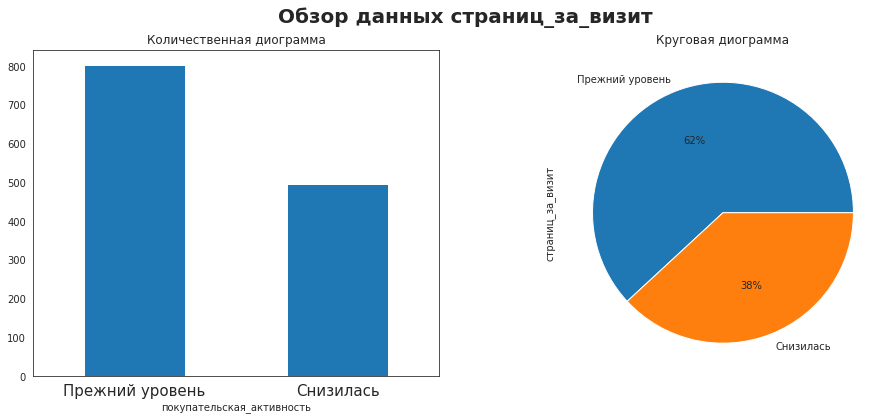

In [98]:
# Для анализа рассмотрим признак страниц_за_визит 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle(f'Обзор данных страниц_за_визит', fontsize = 20, fontweight='bold')
    
market_full.groupby('покупательская_активность')['страниц_за_визит'].count().plot(ax=ax[0], kind='bar')
    
market_full.groupby('покупательская_активность')['страниц_за_визит'].count().plot(ax=ax[1], kind='pie', autopct='%1.0f%%')
    
        
ax[0].set_title(f'Количественная диограмма')
ax[1].set_title(f'Круговая диограмма')
    
    
ax[0].tick_params(axis='x', labelrotation=0, labelsize = 15) 

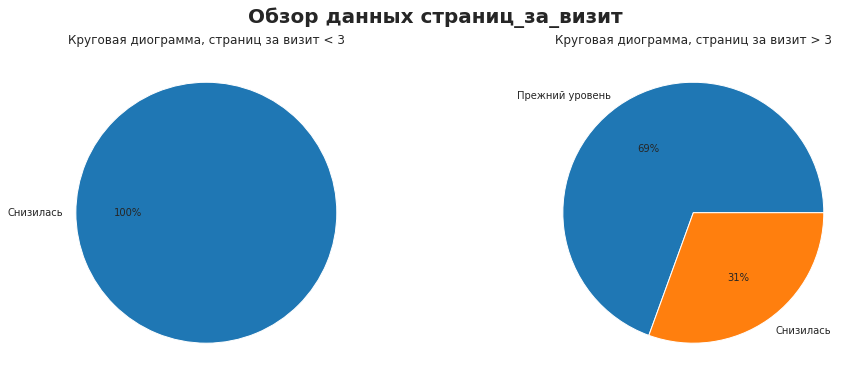

In [99]:
#рассмотрим распределение признака, если среднее количество страниц, 
#которые просмотрел покупатель за один визит за последние 3 месяца меньше 3 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle(f'Обзор данных страниц_за_визит', fontsize = 20, fontweight='bold')
    
market_full[market_full['страниц_за_визит'] < 3].groupby('покупательская_активность')['страниц_за_визит'].count()\
    .plot(ax=ax[0], kind='pie', autopct='%1.0f%%')
    
market_full[market_full['страниц_за_визит'] > 3].groupby('покупательская_активность')['страниц_за_визит'].count()\
    .plot(ax=ax[1], kind='pie', autopct='%1.0f%%')

ax[0].set_title(f'Круговая диограмма, страниц за визит < 3')
ax[1].set_title(f'Круговая диограмма, страниц за визит > 3')
    
ax[0].set_ylabel('')
ax[1].set_ylabel('')

plt.show()

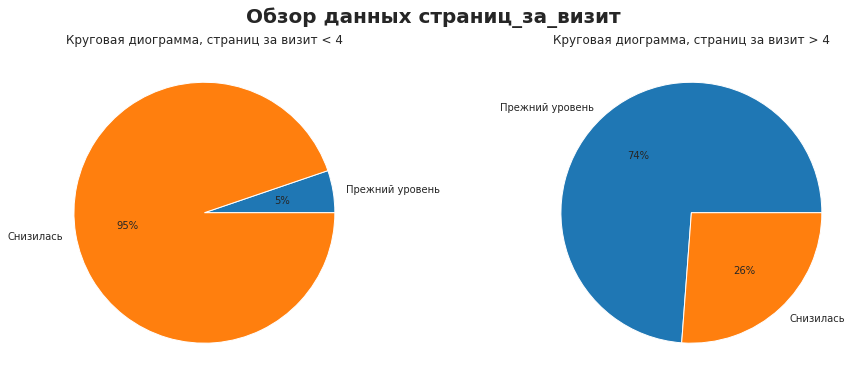

In [100]:
#рассмотрим распределение признака, если среднее количество страниц, 
#которые просмотрел покупатель за один визит за последние 3 месяца меньше 4 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
fig.suptitle(f'Обзор данных страниц_за_визит', fontsize = 20, fontweight='bold')

market_full[market_full['страниц_за_визит'] < 4].groupby('покупательская_активность')['страниц_за_визит'].count()\
    .plot(ax=ax[0], kind='pie', autopct='%1.0f%%')
    
market_full[market_full['страниц_за_визит'] > 4].groupby('покупательская_активность')['страниц_за_визит'].count()\
    .plot(ax=ax[1], kind='pie', autopct='%1.0f%%')

ax[0].set_title(f'Круговая диограмма, страниц за визит < 4')
ax[1].set_title(f'Круговая диограмма, страниц за визит > 4')
    
ax[0].set_ylabel('')
ax[1].set_ylabel('')

plt.show()

**Вывод** 

Сегментацию данных проводила на изначальном датафрейме, в котором уже есть целевой признак для сегментации 'Покупательская активность'. Так как считаю, что делать прогноз на данных участвующих в обучении не корректно. 

Сегментирование данных можно провести по следующим признакам:
- маркет_актив_6_мес
- акционные_покупки
- неоплаченные_продукты_штук_квартал
- страниц_за_визит
- препредыдущий_месяц_выручка
- предыдущий_месяц_время

Для анализа выбрала признак страниц_за_визит, который является наиболее важным для нашей модели.

Из графиков видно, что для пользователей, которые в среднем посмотрели менее 4 страниц за один визит за последние 3 месяца покупательскую активность снизилась на 95%.

Чтобы пользователь смотрел больше страниц на сайте, можно предложить следующие рекомендации:
- Добавить раздел с релевантными рекомендациями 
- Предлагать связанные товары и дополнительные аксессуары
- Улучшить навигацию и структуру сайта
- Оптимизировать скорость загрузки страниц
- Разработать современный дизайн сайта

###  Сегментация на предсказанном признаке 

In [101]:
#Удалим столбец с целевым признаком
market_full_pred = market_full.drop(['покупательская_активность','прибыль'], axis=1)
market_full_pred.head(1)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время
id,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10


In [102]:
#Сделаем предсказания на наших данных
X_test_preprocessed = preprocessor.transform(market_full_pred)
predictions = best_model.predict_proba(X_test_preprocessed)[:, 1]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [103]:
# Зададим порог классификации
threshold = 0.7

pred_final = (predictions > threshold).astype(int)

#Добавим предсказания к нашему датафрейму
market_full_pred['вероятность_снижения'] = predictions
market_full_pred['вероятность_снижения_1_0'] = pred_final
market_full_pred['предсказание'] = market_full_pred['вероятность_снижения_1_0'].apply(lambda x: 'Снизилась' if x == 1 else 'Прежний уровень')

market_full_pred['предсказание'].value_counts()

Прежний уровень    910
Снизилась          386
Name: предсказание, dtype: int64

In [104]:
market_full['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          494
Name: покупательская_активность, dtype: int64

In [105]:
market_full_pred = market_full_pred.join(money)
market_full_pred.head(1)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,вероятность_снижения,вероятность_снижения_1_0,предсказание,прибыль
id,,,,,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.953391,1,Снизилась,4.16


In [106]:
#разобьем наш датафрейм на 2 датафрейма
#Клиенты с высоком прибылью и риском снижения покупательской активности
segmet_target = market_full_pred[(market_full_pred['вероятность_снижения']>0.7) & 
                                 (market_full_pred['прибыль']>3)]
#прочие клиенты
segmet_other =market_full_pred[~market_full_pred.index.isin(segmet_target.index)]


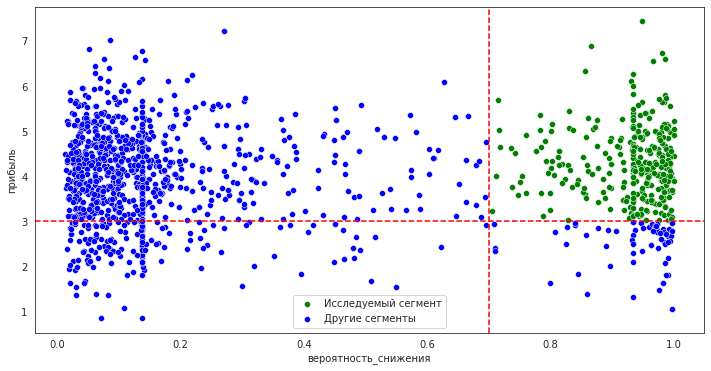

In [107]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=segmet_target, x='вероятность_снижения', y='прибыль', label = 'Исследуемый сегмент', color='green')
sns.scatterplot(data=segmet_other, x='вероятность_снижения', y='прибыль', label = 'Другие сегменты', color='blue')
plt.legend()
plt.axvline(x=0.7, color='red', linestyle='--')
plt.axhline(y=3, color='red', linestyle='--')
plt.show()

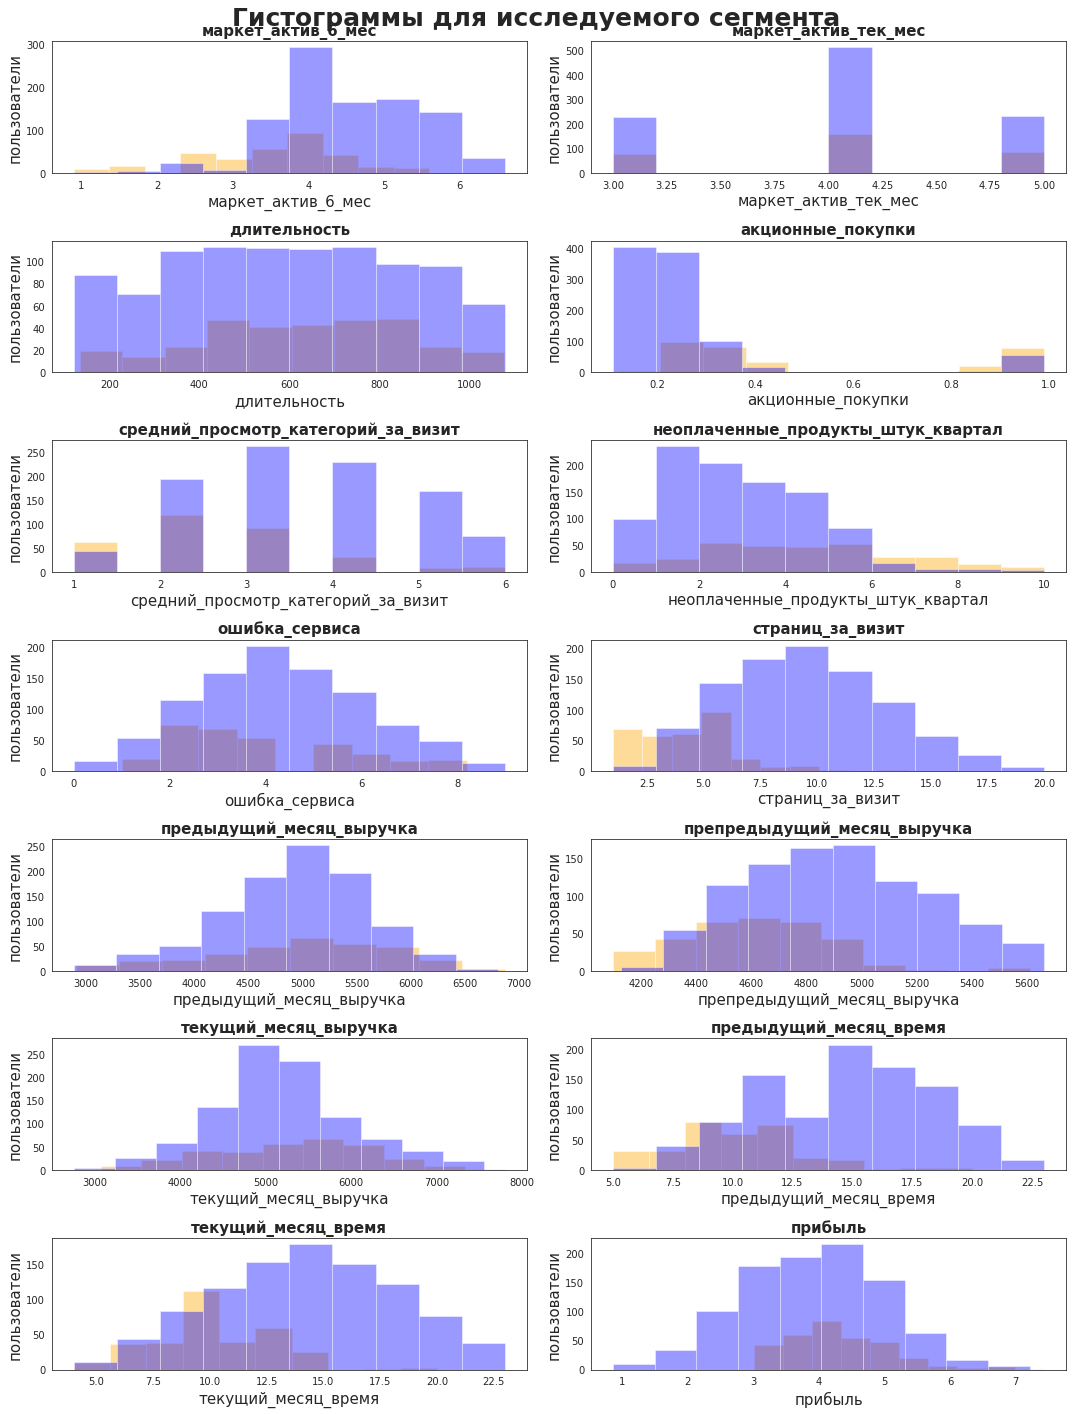

In [108]:
# Построим гистограммы количественных переменных для нашего сегмента
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(15,20))
fig.suptitle(f'Гистограммы для исследуемого сегмента', fontsize = 25, fontweight='bold')

temp = 1
for i in quantitative_variables:
    plt.subplot(7, 2, temp)
    segmet_target[i].sort_values().plot(label='Исследуемый сегмент', color='orange', kind = 'hist', \
            histtype =  'barstacked',alpha = 0.4) 
    segmet_other[i].sort_values().plot(label='Другие сегменты', color='blue', kind = 'hist', \
            histtype =  'barstacked',alpha = 0.4) 
    temp += 1
    plt.title(f'{i}', fontsize = 15, fontweight='bold')
    plt.xlabel(i, fontsize = 15)
    plt.ylabel('пользователи', fontsize = 15)

plt.tight_layout()

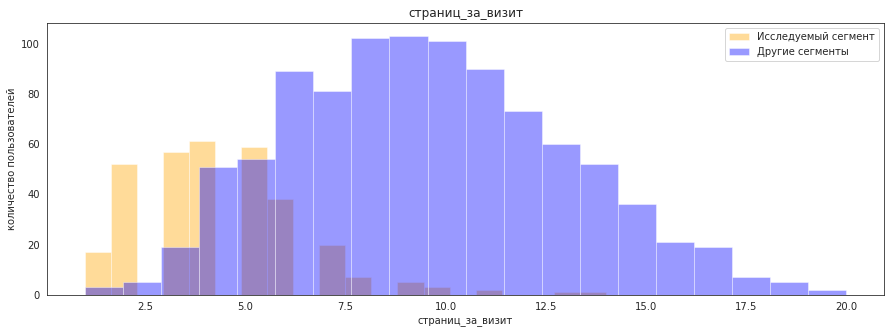

In [109]:
#hрассмотрим сегмент страниц_за_визит
plt.figure(figsize=(15, 5))
segmet_target['страниц_за_визит'].sort_values().plot(label='Исследуемый сегмент', color='orange', kind = 'hist', histtype =  'barstacked',alpha = 0.4, bins = 20) 
segmet_other['страниц_за_визит'].sort_values().plot(label='Другие сегменты', color='blue', kind = 'hist', histtype =  'barstacked',alpha = 0.4, bins = 20) 
plt.legend() 
plt.title('страниц_за_визит')
plt.xlabel('страниц_за_визит')
plt.ylabel('количество пользователей')
plt.show()

**Вывод**

Сегментацию данных проводила на данных с предсказанным целевым признаком.

Из графиков видно, покупательская активность снизилась для пользователей, которые в среднем посмотрели менее 5 страниц за один визит за последние 3 месяца.

Чтобы пользователь смотрел больше страниц на сайте, можно предложить следующие рекомендации:

Добавить раздел с релевантными рекомендациями 
- Предлагать связанные товары и дополнительные аксессуары 
- Улучшить навигацию и структуру сайта 
- Оптимизировать скорость загрузки страниц 
- Разработать современный дизайн сайта

## Общий вывод

<h1>Проект: Обучение с учителем: качество модели</h1>

**Описание проекта** Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель исследования**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

В качестве данных были предоставлены 4 таблицы.
- `market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time.csv` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `money.csv` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

---

**На этапе загрузки данных:** убедились, что данные соответствуют описанию, явных дубликатов нет, пропуски отсутствуют, типы столбцов указаны верно. Название столбцов приведены к единому стиля написания Snake case.

**На этапе предобработки данных и исследовательского анализа:**  Более глубоко изучили данные с помощью графических инструментов и описательных функций. 

Данные в таблицах реалистичны и соответствуют описанию.

На этапе предобработке данных проверили, что в данных:

- нет пропусков
- нет дубликатов
- типы столбцов указаны верно
- исправили опечатки

В данных встречаются выбросы, но они реалистичны по значениям. 

Выбросы встретились в столбцах:

- 'маркет_актив6мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал' market_file
- 'выручка' датафрейма market_money
- 'прибыль' датафрейма money

---

**На этапе объединения данных**

Удалили клиентов которые не совершали покупок, хотя бы в одном из трех месяцев, а так же клиента с аномально большой выручкой в текущем месяце


---

**Корреляционный анализ**

Из матрицы видем, что признаки препредыдущий_месяц_выручка/предыдущий_месяц_выручка/текущий_месяц_выручка коррелируют между собой.

Данную связь легко объяснить, интернет-магазин «В один клик» продаёт разные товары. Если человек привык покупать определенный набор продуктов, моющих средств и других товаров необходимых в ежедневном использовании, то большая доля вероятности, что он купит эти же товары и в следующем месяце. Как правило одни и те же типы товаров мы покупаем в одних и тех же магазинах (так как в качестве товара ты уже уверен и времени на поиск товара занимает меньше). Отсюда и выручка от одних и тех же клиентов остается стабильной. Но избавляться хоть от одного из них считаю некорректно, если удалим хоть один из них, то уже не сможем правильно предсказывать активность пользователей.

Связь между покупательской активностью и другими признаками, тоже объяснима:

покупательская активность/выручка. Чем больше выручка, тем выше покупательская активность
покупательская активность/страниц_за_визит. Чем больше товаров просмотрел пользователь, тем выше покупательская активность
покупательская активность/время на сайте. Чем больше времени пользователь проводит на сайте, тем выше покупательская активность

---

**Использование пайплайнов**

Для поиска лучшей модели:

- была проведена подготовка данных 
- в качестве моделей рассматривались: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()
- для каждой модели был подобран как минимум один гиперпараметр
- для перебора моделей и параметров использовали метод RandomizedSearchCV
- в качестве метрики оценки модели была выбрана - ROC-AUC.

С помощью пайплайнов мы подобрали лучшие модели на данных с выбросами и без. Обе модели хороши, но модель построенная на данных без выбросов оказалась чуть лучше.

Лучшей моделью оказалась:

- SVC(probability=True, random_state=42)
- Метрика лучшей модели на тренировочной выборке: 0.90
- Метрика ROC-AUC на тестовой выборке: 0.92

---
**Анализ важности признаков**

Наиболее важными признаками модели являются:
- страниц_за_визит важность	0.014760
- средний_просмотр_категорий_за_визит важность 0.012765

ошибка_сервиса (-0.001035), неоплаченные_продукты_штук_квартал (-0.001747), маркет_актив_тек_мес (-0.002702) имеют отрицательную важность, что означает, что они не вносят положительный вклад в модель.

Зная, какие признаки сильнее всего влияют на целевой признак, можно сконцентрироваться на сборе и анализе данных, связанных с этими признаками. Это может помочь в оптимизации модели и принятии более обоснованных бизнес-решений.


В нашем случае, чтобы удержать активность постоянных клиентов интернет-магазина «В один клик», можно предложить показывать в рекомендации товары, аналогичные тем, которые он смотрел в эту сессию, или даже в прошлом месяце, чтобы увеличить среднее количество страниц, которые просмотрел покупатель за один визит.

---

**Сегментация покупателей**

Сегментацию данных проводила на данных с предсказанным целевым признаком.

Из графиков видно, покупательская активность снизилась для пользователей, которые в среднем посмотрели менее 5 страниц за один визит за последние 3 месяца.

Чтобы пользователь смотрел больше страниц на сайте, можно предложить следующие рекомендации:

Добавить раздел с релевантными рекомендациями

- Предлагать связанные товары и дополнительные аксессуары
- Улучшить навигацию и структуру сайта
- Оптимизировать скорость загрузки страниц
- Разработать современный дизайн сайта